In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Configure Pandas to display all columns and rows
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Load the dataset from the specified Excel file and sheet
df = pd.read_excel('G_Dataset.xlsx', sheet_name='DB')
# Set the second row as the header
df.columns = df.iloc[1]

# Drop the first two rows and reset the index
df = df.drop([0, 1]).reset_index(drop=True)

# Save the cleaned DataFrame to CSV for backup
df.to_csv('df.csv')

In [3]:
# Sort the DataFrame by the 'Week starting sell-out' column
df = df.sort_values(by='Week starting sell-out')

# Convert 'Week starting sell-out' to datetime format for further analysis
df['Week starting sell-out'] = pd.to_datetime(df['Week starting sell-out'])

In [5]:
# Filter relevant columns for digital marketing analysis
df_digital = df[['YEAR', 'N WEEK', 'Week starting sell-out', 'Value Sales Brand', 'Volume Sales Brand',
                 'IMPRESSIONS YOUTUBE', 'IMPRESSIONS OTHER VIDEO PUBLISHERS', 'IMPRESSIONS SOCIAL META',
                 'IMPRESSIONS SPOTIFY', 'IMPR. TIKTOK', 'IMPR. TWITCH',
                 'IMPRESSIONS INFLUENCER MARKETING TIKTOK', 'IMPRESSIONS INFLUENCER MARKETING INSTAGRAM',
                 'INV YOUTUBE', 'INV OTHER VIDEO PUBLISHERS', 'INV SOCIAL META', 'INV GOOGLE SEARCH',
                 'INV AMAZON SEARCH', 'INVESTMENT TIKTOK', 'INVESTMENT TWITCH',
                 'INVESTMENT INFLUENCER MARKETING TIKTOK', 'INVESTMENT INFLUENCER MARKETING INSTAGRAM']]

# Save the filtered DataFrame to CSV
df_digital.to_csv('df_digital.csv')

In [7]:
# Function to aggregate digital and brand investments
def investments(df):
    # Define the groups of investment columns
    digital_investments = ['INV YOUTUBE', 'INV OTHER VIDEO PUBLISHERS', 'INV GOOGLE SEARCH', 'INV AMAZON SEARCH',
                           'INVESTMENT TIKTOK', 'INVESTMENT TWITCH', 'INV SOCIAL META',
                           'INVESTMENT INFLUENCER MARKETING TIKTOK', 'INVESTMENT INFLUENCER MARKETING INSTAGRAM']
    brand_investments = ['INVESTMENTS TV', 'INVESTMENTS PRINT']

    # Calculate the sum of digital and brand investments
    df['digital_investments'] = df[digital_investments].sum(axis=1)
    df['brand_investments'] = df[brand_investments].sum(axis=1)

    # Drop the original columns that were summed up
    df = df.drop(digital_investments + brand_investments, axis=1)
    return df

# Apply the aggregation function to the main DataFrame
df_investments = investments(df)

In [9]:
# Function to consolidate and rename columns for easier analysis
def consolidate_columns(df):
    # Rename inconsistent column names
    df.rename(columns={'GRP_COMP 1 ': 'GRP_COMP 1',
                       'Value Sales in promo - Price Cut': 'promo_cut',
                       'Value Sales in promo - Bundle': 'promo_bundle'}, inplace=True)

    # Group columns for aggregation
    digital_impressions = ['IMPRESSIONS YOUTUBE', 'IMPRESSIONS OTHER VIDEO PUBLISHERS', 'IMPRESSIONS SPOTIFY',
                           'IMPR. TIKTOK', 'IMPR. TWITCH', 'IMPRESSIONS SOCIAL META',
                           'IMPRESSIONS INFLUENCER MARKETING TIKTOK',
                           'IMPRESSIONS INFLUENCER MARKETING INSTAGRAM']
    tv_grp = ['GRP TV', "GRP TV 20''", "GRP TV 10''"]
    competitors_grp = [f'GRP_COMP {i}' for i in range(1, 15)]  # Generate competitor columns dynamically
    editors_columns = ['NUMBER OF EDITORIALS PRINTED', 'NUMBER OF EDITORIALS ONLINE']
    totem_columns = ['TOTEM DISPLAY IN STORE', 'TOTEM DISPLAY NEXT TO CASHIER']
    seasonal_events = ['CHRISTMAS', 'NEW YEAR\'S EVE', 'EASTER', 'MID AUGUST', 'MOM\'S DAY', 'BLACK FRIDAY']

    # Aggregate column groups
    df['digital_impressions'] = df[digital_impressions].sum(axis=1)
    df['tv_grp'] = df[tv_grp].sum(axis=1)
    df['competitors_grp'] = df[competitors_grp].mean(axis=1)
    df['total_editors'] = df[editors_columns].sum(axis=1)
    df['total_totem'] = df[totem_columns].sum(axis=1)
    df['events_seasonal'] = df[seasonal_events].sum(axis=1)

    # Drop original columns after aggregation
    df = df.drop(digital_impressions + tv_grp + competitors_grp + editors_columns + totem_columns + seasonal_events,
                 axis=1)
    return df

# Apply consolidation to the DataFrame
df_consolidated = consolidate_columns(df_investments)
df_consolidated.to_csv('df_consolidated.csv')

In [11]:
# Function to drop unnecessary columns
def df_drop(df):
    df = df.drop(['YEAR', 'Market Value Data', 'Market Volume Data', 'Volume Sales Brand',
                  '% Value Promo Cut Price', '% Value Promo Bundle',
                  'PRICE INDEX VS REST MKT (<100 IS LOWER THAN MARKET)'], axis=1)
    return df

# Apply the drop function to the consolidated DataFrame
df_processed = df_drop(df_consolidated)


In [13]:
# Function to clean and enrich the DataFrame with additional metrics
def df_clean(df):
    # Calculate GRP erosion (difference between TV GRP and competitor GRP)
    df = df.assign(grp_erosion=df['tv_grp'] - df['competitors_grp'])

    # Determine the season based on week number
    def week_season(week):
        if week <= 12 or week >= 50:
            return 'Winter'
        elif week < 25:
            return 'Spring'
        elif week < 37:
            return 'Summer'
        else:
            return 'Fall'

    # Apply seasonal classification to the DataFrame
    df["season"] = df["N WEEK"].apply(week_season)

    # Extract the month from 'Week starting sell-out' column
    df['month'] = pd.DatetimeIndex(df['Week starting sell-out']).month

    # Drop columns that are no longer needed
    df = df.drop(['N WEEK', 'Week starting sell-out'], axis=1)

    # Calculate percentage change in sales value
    df['Sales Value Growth (%)'] = df['Value Sales Brand'].pct_change() * 100
    df['Sales Value Growth (%)'] = df['Sales Value Growth (%)'].fillna(0)

    return df

# Clean the processed DataFrame
df_pure = df_clean(df_processed)

/var/folders/f0/nc46h10539q_2c9xxx6pctt00000gn/T/ipykernel_48988/1820562696.py:27: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Sales Value Growth (%)'] = df['Value Sales Brand'].pct_change() * 100


Original DataFrame shape: (208, 29)
Categorical DataFrame shape: (208, 2)
Numerical DataFrame shape: (208, 27)


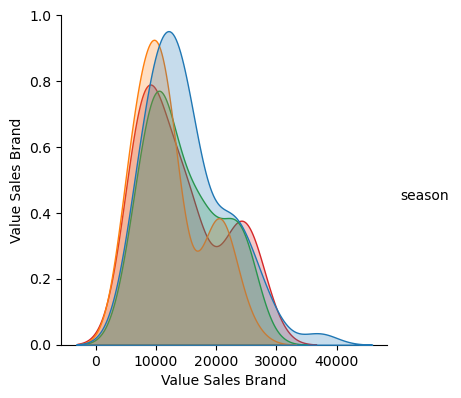

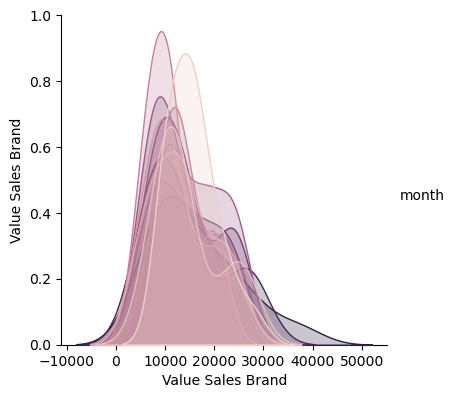

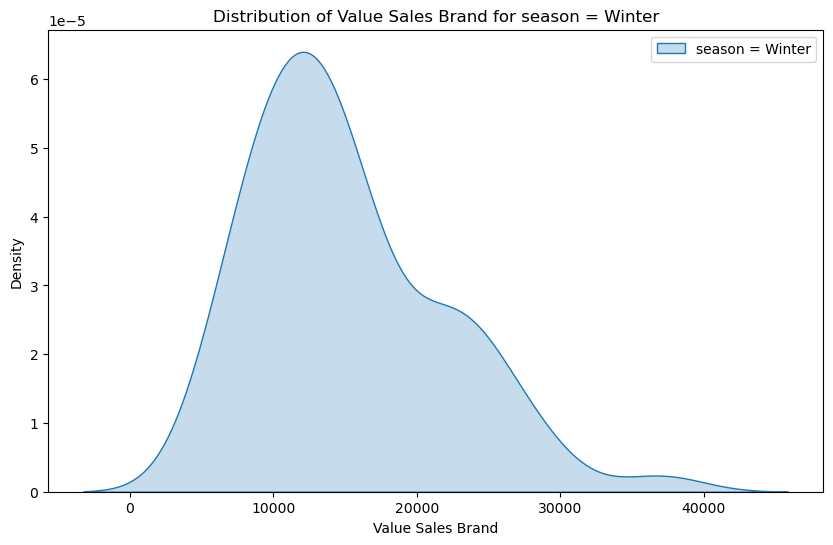

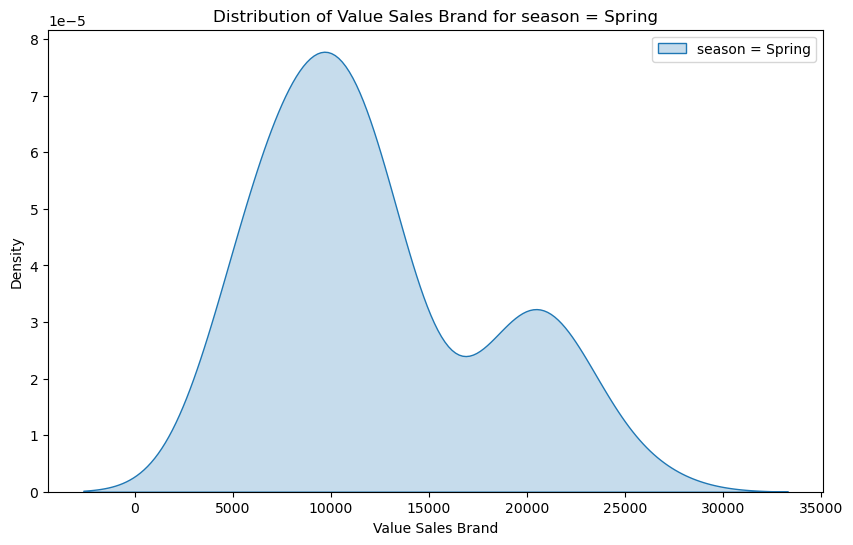

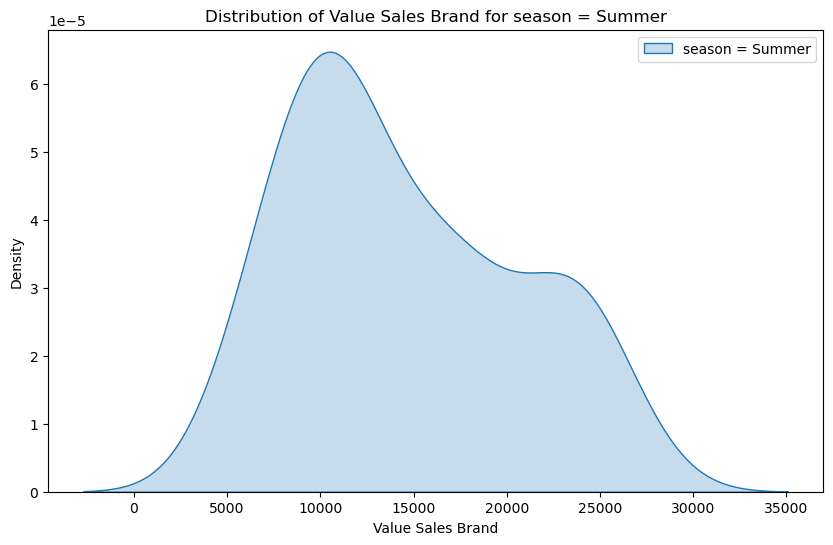

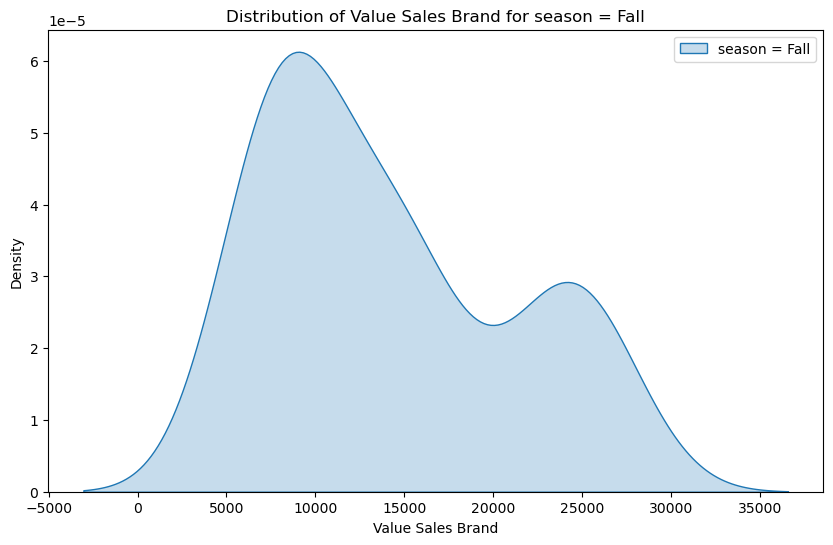

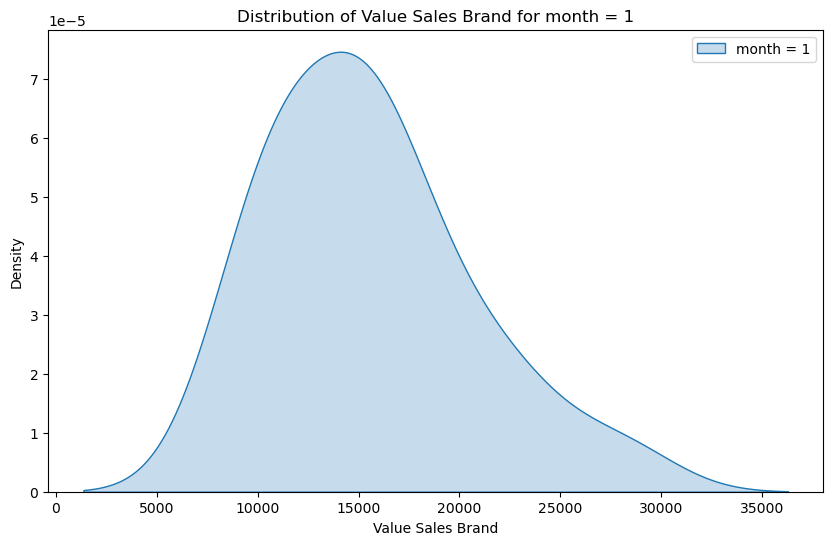

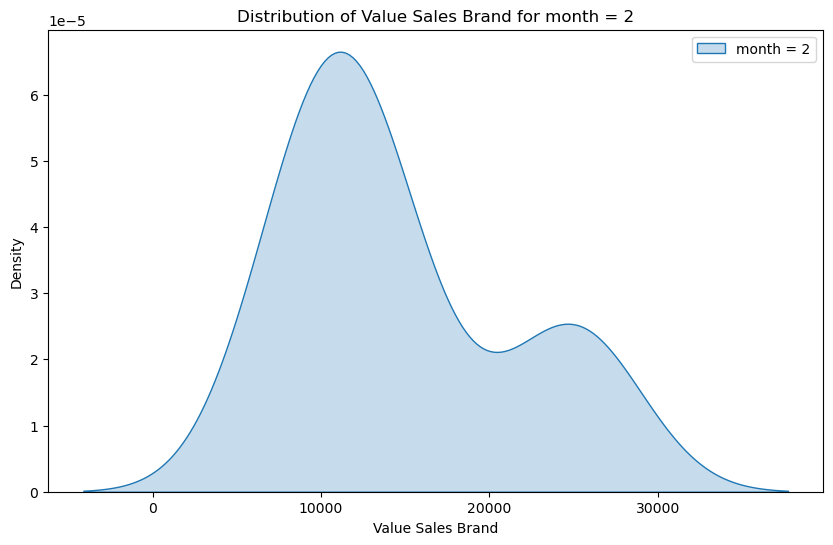

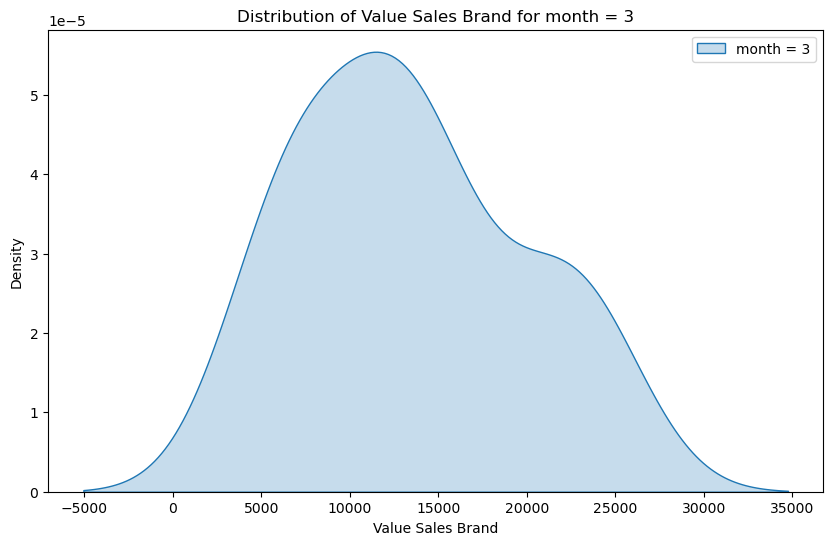

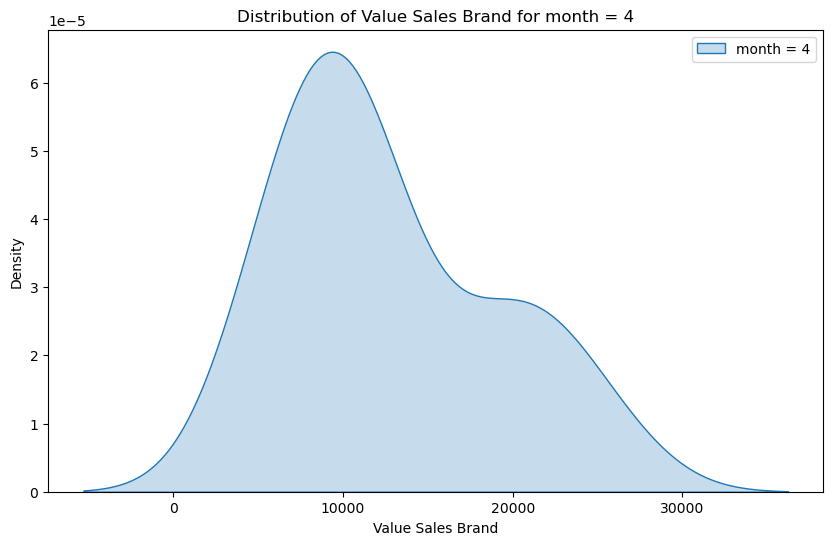

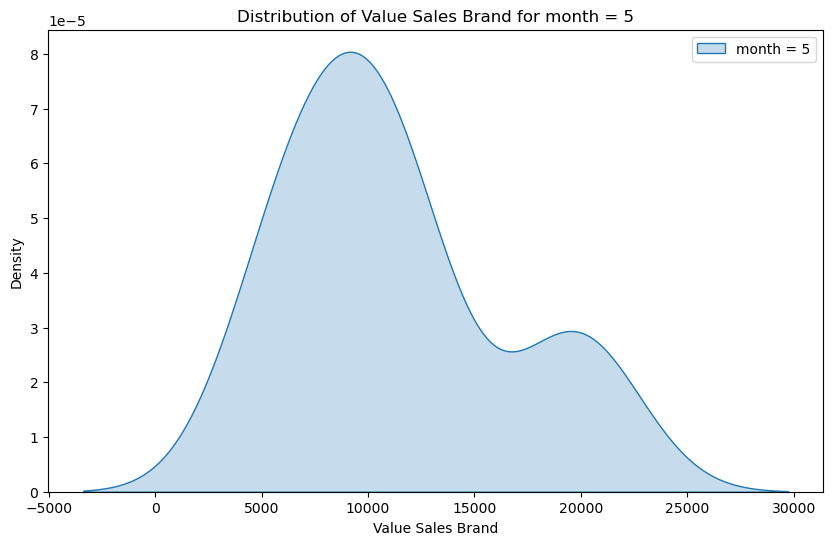

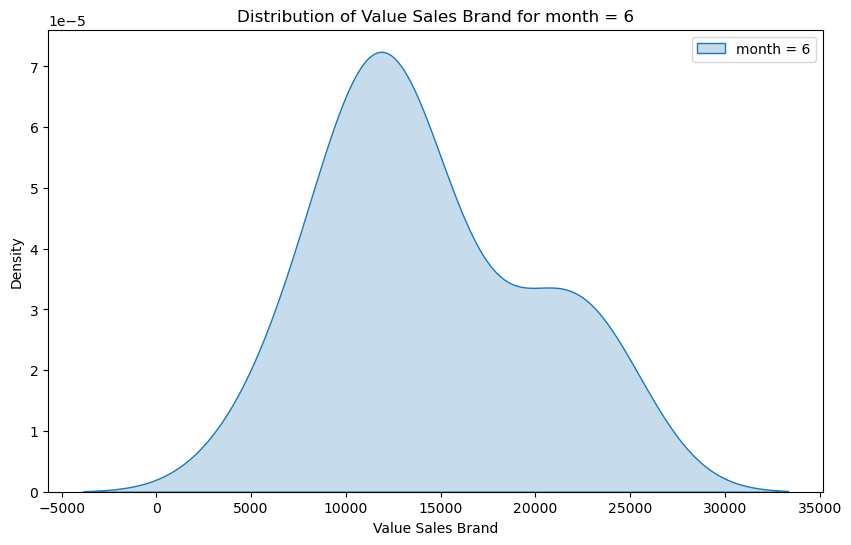

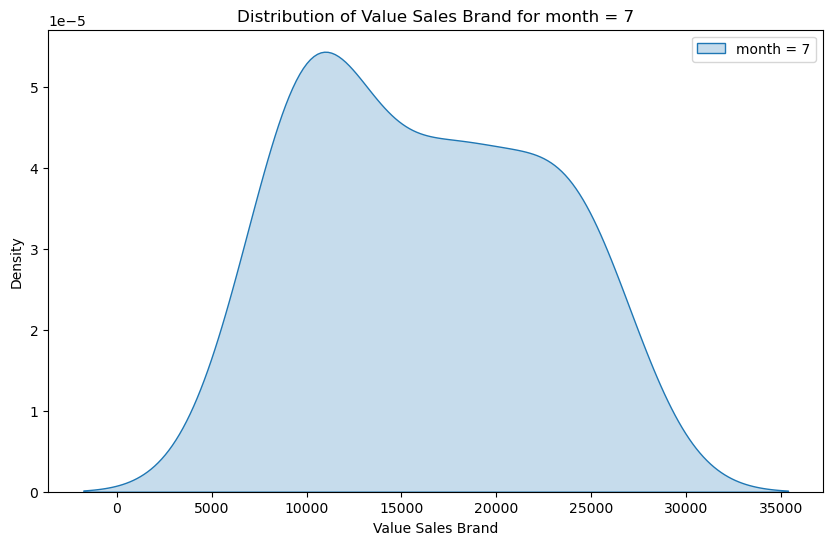

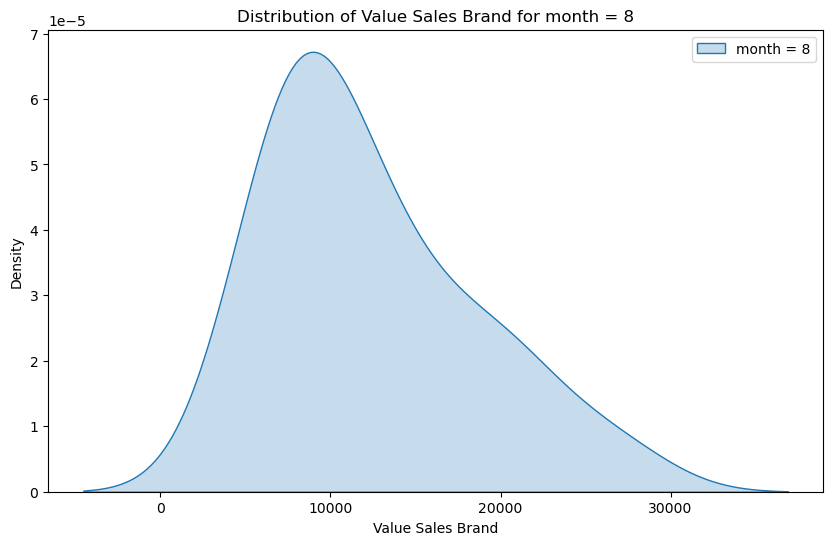

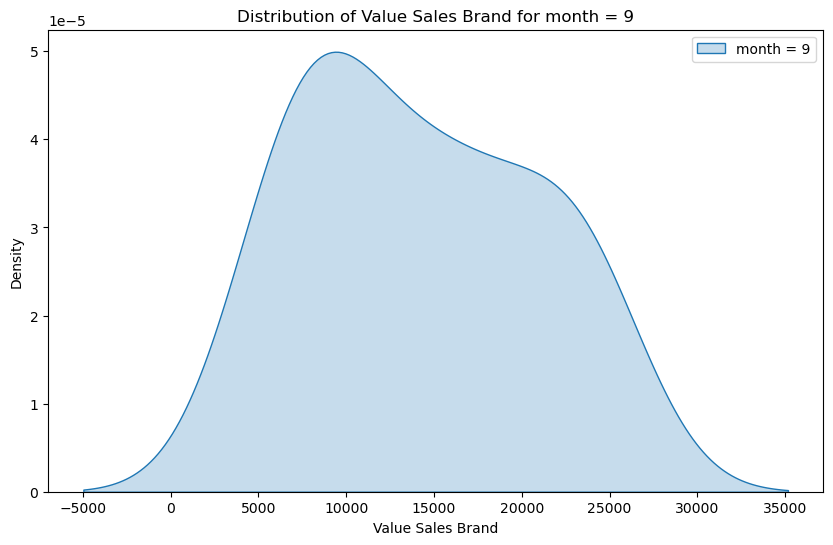

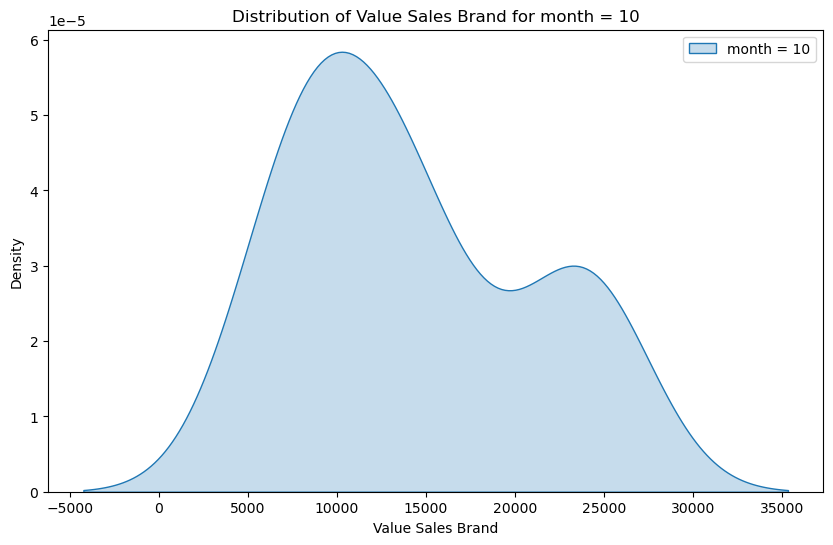

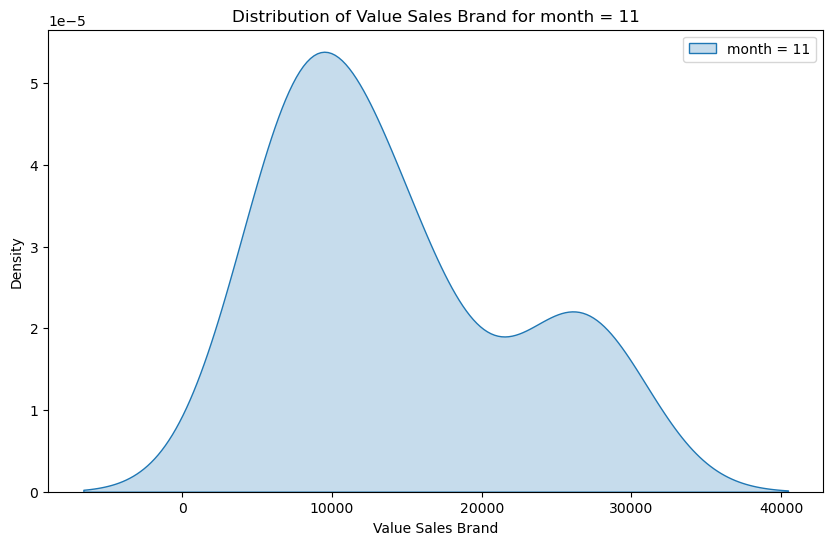

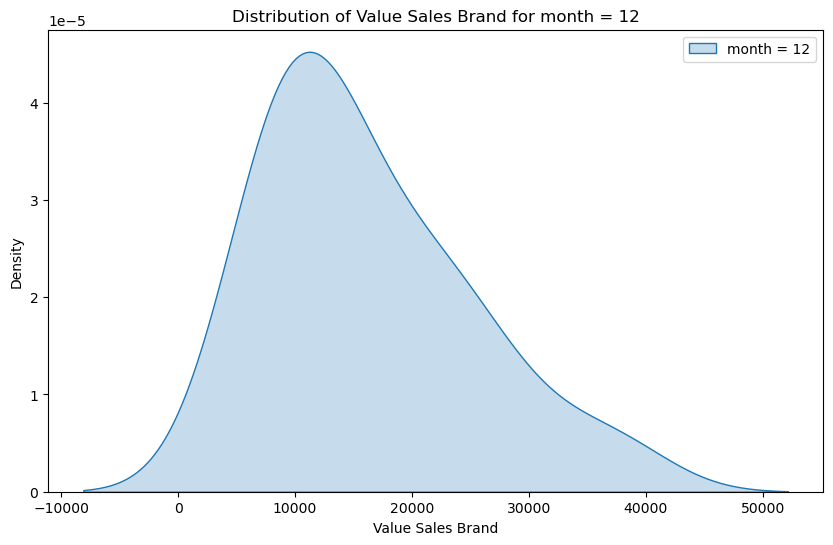

Dummies with all categorical variables shape: (208, 16)
Dummies without 'season' shape: (208, 12)
Dummies without 'month' shape: (208, 4)


In [15]:
#Division into numerical and categorical variables
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define target variable
target_variable = 'Value Sales Brand'

# Separate categorical and numerical variables
df_cat = df_pure[['season', 'month']]
df_num = df_pure.drop(['season', 'month'], axis=1)

# Print shapes of the original, categorical, and numerical dataframes
print("Original DataFrame shape:", df_pure.shape)
print("Categorical DataFrame shape:", df_cat.shape)
print("Numerical DataFrame shape:", df_num.shape)

# Plot pairplots for each categorical variable against the target variable
for col in df_cat.columns:
    sns.pairplot(data=df_pure[[target_variable, col]], hue=col, height=4)
    plt.show()

# Plot the distribution of the target variable according to each categorical variable
for col in df_cat.columns:
    unique_values = df_pure[col].unique()
    for value in unique_values:
        plt.figure(figsize=(10, 6))
        subset = df_pure[df_pure[col] == value]
        sns.kdeplot(subset[target_variable], label=f'{col} = {value}', fill=True)
        plt.title(f'Distribution of {target_variable} for {col} = {value}')
        plt.xlabel(target_variable)
        plt.ylabel('Density')
        plt.legend()
        plt.show()

# Create dummy variables for categorical data
dummies_1 = pd.get_dummies(df_cat.astype(str))

# Create dummy variables excluding 'season' and 'month' separately
selected1_no_season = pd.get_dummies(df_cat.drop(['season'], axis=1).astype(str))
selected1_no_month = pd.get_dummies(df_cat.drop(['month'], axis=1).astype(str))

# Print shapes of the dummy DataFrames
print("Dummies with all categorical variables shape:", dummies_1.shape)
print("Dummies without 'season' shape:", selected1_no_season.shape)
print("Dummies without 'month' shape:", selected1_no_month.shape)

In [17]:
# Changing the type to integer
selected1 = selected1_no_month.astype(int)
selected1

,season_Fall,season_Spring,season_Summer,season_Winter
1,0,0,0,1
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1
6,0,0,0,1
7,0,0,0,1
8,0,0,0,1
9,0,0,0,1
10,0,0,0,1
11,0,0,0,1


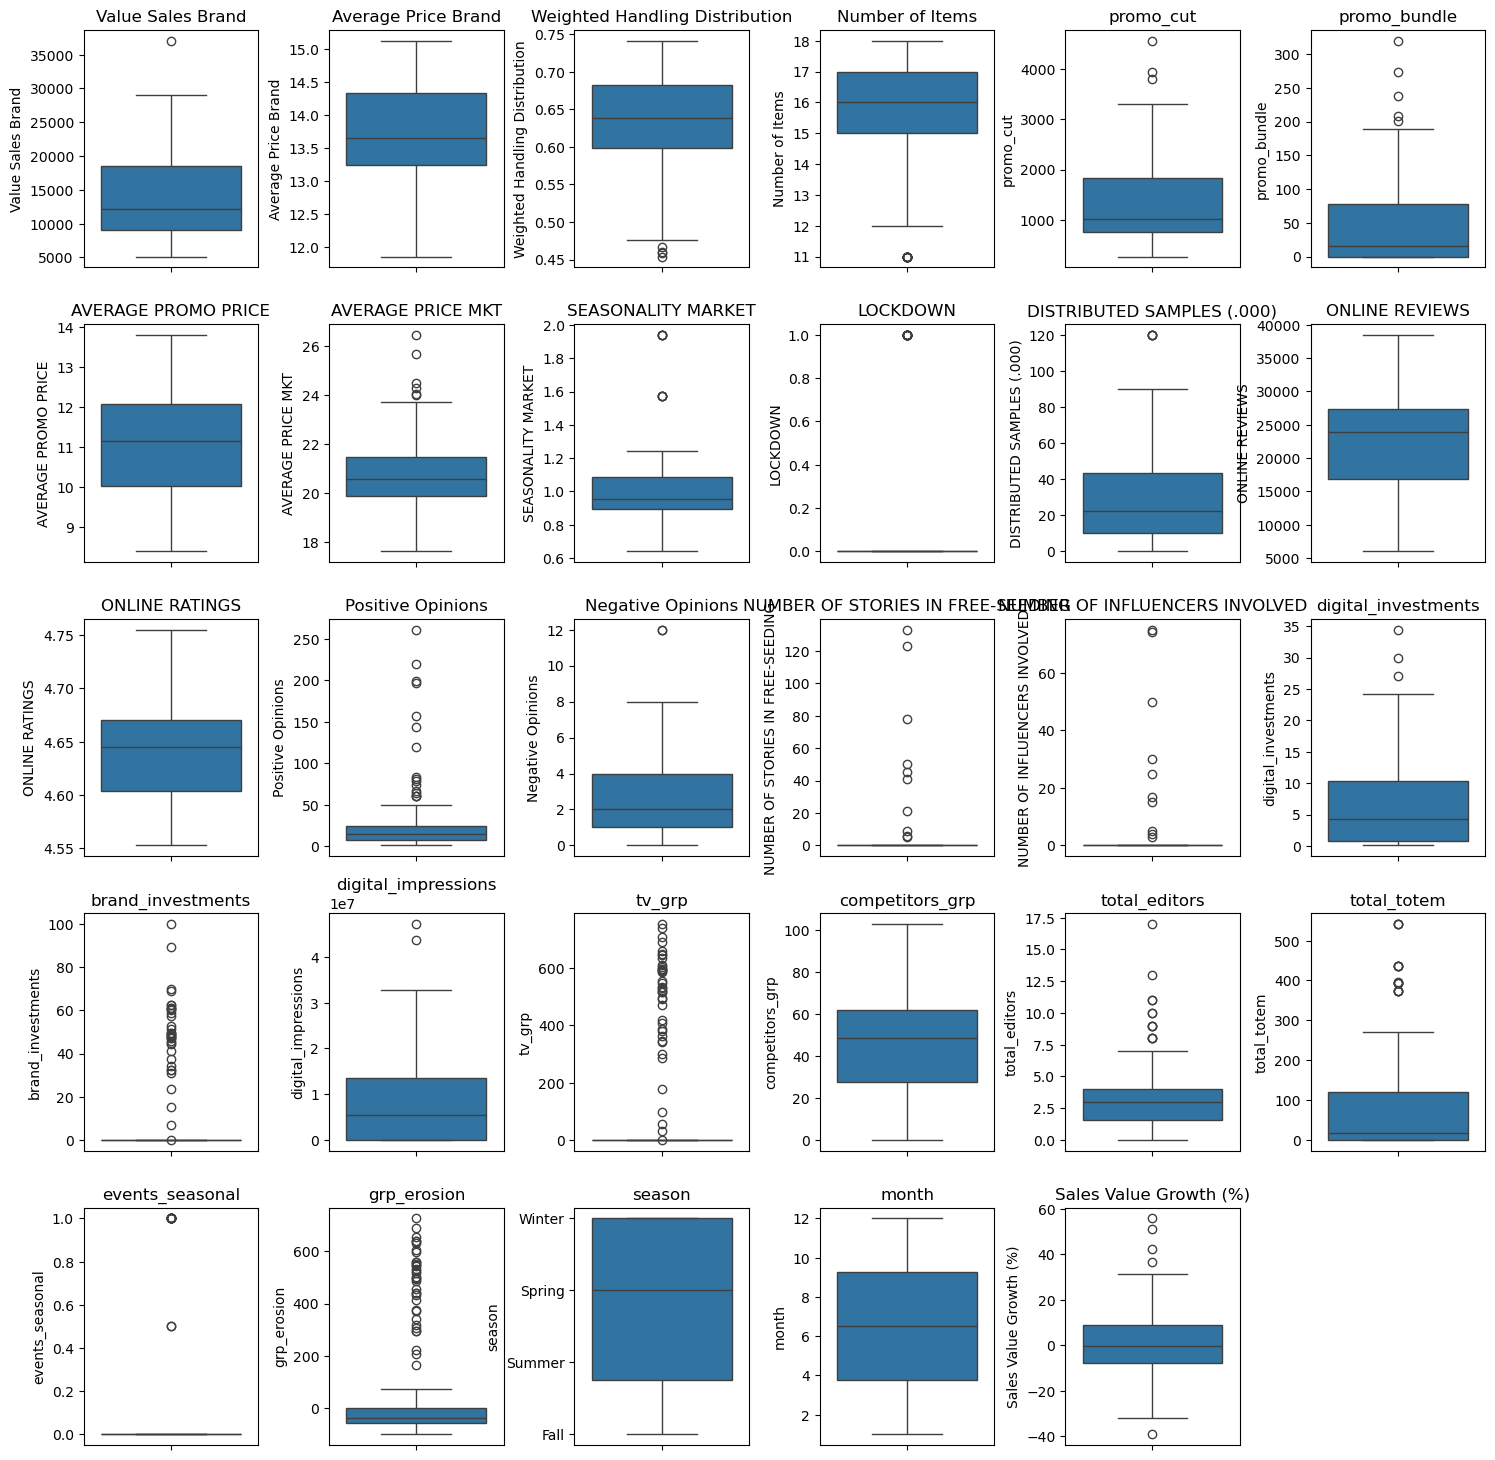

In [19]:
#We use boxplots to visualize the distribution of each column of data.
# Number of columns in the DataFrame
num_columns = len(df_pure.columns)

# Determine the number of rows and columns for the subplots grid
num_cols = 6
num_rows = (num_columns + num_cols - 1) // num_cols  # Ceiling division

fig, axes = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(15, 3*num_rows))
fig.tight_layout(pad=2)

# Flatten the axes array for easier indexing
axes = axes.flatten()

for i, col in enumerate(df_pure.columns):
    sns.boxplot(y=col, data=df_pure, orient='v', ax=axes[i])
    axes[i].set_title(col)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()

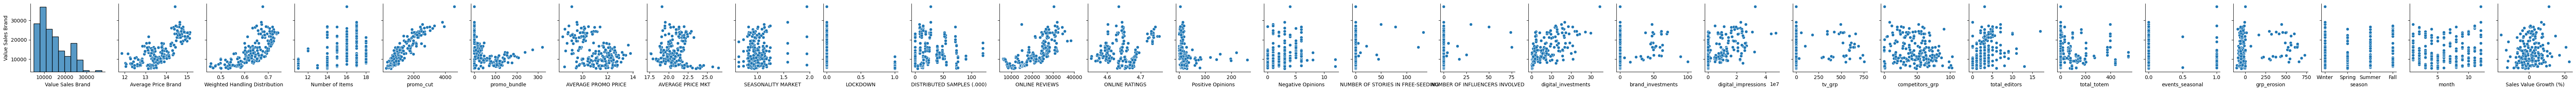

In [21]:
# Create a pairplot to visualize the relationships between all the variables in the df_pure DataFrame and the 'Value Sales Brand' column.
sns.pairplot(df_pure, x_vars=df_pure.columns, y_vars='Value Sales Brand')

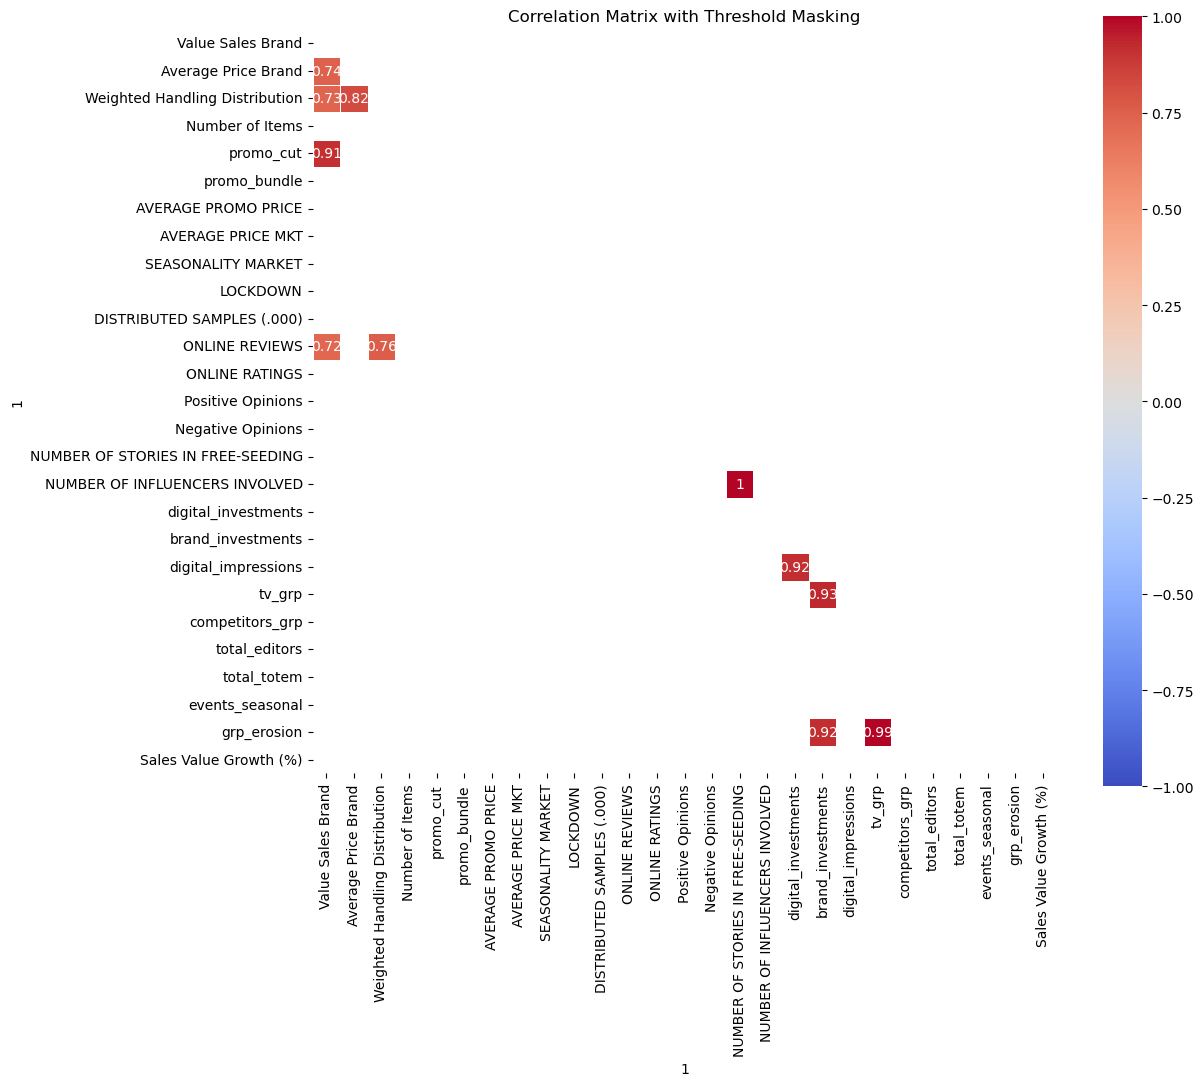

In [23]:
# Create a correlation matrix to see correlation between variables
# Compute the correlation matrix
corr_matrix = df_num.corr()

# Define the threshold
threshold = 0.7

# Mask the correlations below the threshold
mask_below_threshold = abs(corr_matrix) < threshold
filtered_corr_matrix = corr_matrix.mask(mask_below_threshold)

# Generate a mask for the upper triangle
mask_upper_triangle = np.triu(np.ones_like(filtered_corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(filtered_corr_matrix, mask=mask_upper_triangle, cmap='coolwarm', annot=True, square=True, vmin=-1, vmax=1, linewidths=.5)

plt.title('Correlation Matrix with Threshold Masking')
plt.show()

In [25]:
# Merge numerical and categorical variables
first_df= pd.concat([df_num, selected1], axis = 1)

# Save the DataFrame to a CSV file
first_df.to_csv('first_df.csv', index=False)